# CS166 Assignment 2: Traffic simulation

In this assignment, you will build cellular automata to model traffic flow.

Each cell is about the size of a car and cars travel along a road, passing other cars if they can. You will see how cellular automata can be used to model some realistic traffic patterns and explore what happens if driver behavior changes.

## Part 1: Traffic jams on a circular road

For Part 1, implement the single lane, variable-speed traffic model described in <a href="https://course-resources.minerva.kgi.edu/uploaded_files/mke/YpqvNV/nagel-schreckenberg.pdf">Nagel, K., Schreckenberg, M. (1992). A cellular automaton model for freeway traffic. Journal de Physique I, 2(12), 2221–2229</a>.

Deliverables:
- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show how traffic jams can appear when traffic density is high enough.
- Analyze how the overall average traffic flow rate varies with traffic density and present your results in your report.

In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [27]:
class CircularTrafficSimulation():
    
    def __init__(self, length = 100, density = 0.2, max_velocity = 5, prob = 0.3):
        '''
        Here, we define the model parameters (road length, traffic density, maximum velocity, 
        probability of slowing down)
        '''
        self.length = length # The length of the road (number of cells)
        self.density = density # The density of traffic
        self.max_velocity = max_velocity # The maximum speed of the cars
        self.slow_prob = prob # The probability of slowing down for no apparent reason
        self.flow = 0 # Flow counter to track the number of cars exiting the road on the left side after 
                      # each time step.
        
        '''Creating the lane and populating it with cars'''
        self.state = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        filled_cells = np.random.choice(range(self.length), size=int(round(density * self.length)), replace=False)
        self.state[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
        
        '''Track the time steps and total number of cars that passed the simulation boundary 
        to estimate average traffic flow.'''
        self.time_step = 0
        self.cumulative_traffic_flow = 0
            
    
    def step(self, display = True):  
        
        '''Here, we iterate across the cells and change the speed of the cars in each cell accordingly'''
        for i in range(self.length):
            if self.state[i] != -1: # We only change the speed if there's a car in the cell
                dist = 0 # Algorithm that scans the grids in front of the car until it finds the next car
                while self.state[(i + (dist + 1)) % self.length] == -1:
                        dist += 1
                
                '''Here we will code for the 3 rules for speed change in the Nagel-Schreckenberg model'''
                if dist > self.state[i] and self.state[i] < self.max_velocity: # acceleration
                    self.state[i] += 1 
                if dist < self.state[i]: # deceleration
                    self.state[i] = dist 
                if self.state[i] > 0 and np.random.random() < self.slow_prob: # random slowdown
                    self.state[i] -= 1                   
        
        '''Here we are coding for the last rule in the Nagel-Schrekenberg model - the movement rule'''
        next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.state[i] != -1:
                next_state[(i + self.state[i]) % self.length] = self.state[i]
        self.state = next_state  
        
        '''Update time and traffic flow'''
        self.time_step += 1
        for i in range(self.max_velocity):
            if self.state[i] > i:
                self.cumulative_traffic_flow += 1
                
        '''Display the cells'''
        if display:
            self.display()
    
    
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        
sim = CircularTrafficSimulation()
for i in range(30): # Run the code for 30 timesteps
    sim.step()  

...3...3.....3..1.1........3...2.0.....4.....1..2...1.1000..............2..............4.........0.0
1.....3....4...20..1.........2..10..........5.1....3.1000.1................3................5....0..
..2......3...2.0.1...2.........200..........0...2...1000.1..2..................4...............3..1.
.....3......3.10...2....3......00.1..........1.....3000.1.1....3...................4............1..1
.2.......4..0.00......3.....4..0.1..2..........2...000.10...2......4....................5.........2.
2...3.....1..10.1.........4..1.0...2...3.........2.00.10.1....2.........5....................5......
..2.....4...20.1.1..........2.1.1.....3...3......0.00.00...2.....3...........5....................5.
2....3.....30.1.1..2.........1.1..2......3...3...0.0.10.1.....3......4............5.................
...3.....4.0.1.1..2...3.......1..2...3......3...3.1.10.1.1.......3........5...........4.............
.......4..1.1.1.1....3....4....1....3....4.....3.10.00..1..2.........4........4............

## Calculating Traffic Flow For Circular Traffic Model

Since we have already modified the code above to include a flow counter in the initialization method, as well as at the end of the step method, we can start running the simulation a bunch of times to get the average traffic flow for each.

In [28]:
data_flow = []
data_density = []
for density in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    #print('Density:', density)
    data_density.append(density)
    data_flow.append([])
    for run in range(10):
        sim = CircularTrafficSimulation(density=density)
        for i in range(50):
            sim.step(display=False)
        data_flow[-1].append(sim.cumulative_traffic_flow / sim.time_step)

Finally, we will plot the results into a graph and to visualize the flow of traffic over various densities of traffic.

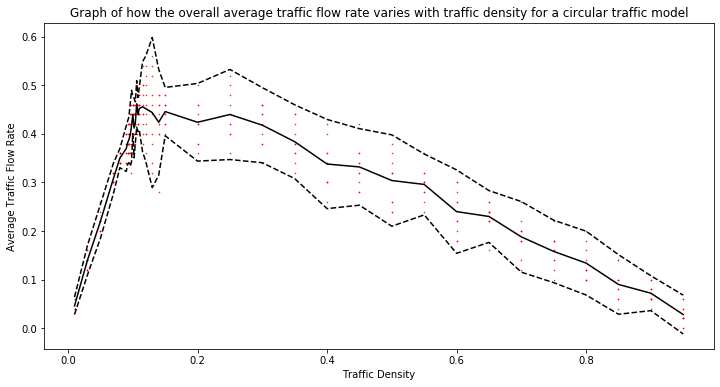

In [29]:
m = np.mean(np.array(data_flow), axis=1)
s = np.std(np.array(data_flow), axis=1)
plt.figure(figsize=(12, 6))
plt.plot(data_density, data_flow, 'r.', markersize=1)
plt.plot(data_density, m, 'k-')
plt.plot(data_density, m + 1.96*s, 'k--')
plt.plot(data_density, m - 1.96*s, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Average Traffic Flow Rate')
plt.title('Graph of how the overall average traffic flow rate varies with traffic density for a circular traffic model')
plt.show()

Inferring from the graph above, we notice that as the traffic density increases, the traffic flow rate increases sharply until its optimum point at ``density ~ 0.1``. From that point on, the flow rate starts decreasing all the way down to zero, where ``density = 1`` and the cars can no longer move.

We also notice that the standard deviation (the dotted lines) is quite huge. This can be reduced greatly by increasing the number of ``run`` trials we perform above - but this also increases the time taken exponentially.

## Part 2: Multi-lane highways

Implement the 2-lane, symmetric, uni-directional, variable speed model in <a href="https://course-resources.minerva.kgi.edu/uploaded_files/mke/00100888-7879/rickert-et-al.pdf">Rickert, M., et al. (1996). Two Lane Traffic Simulations using Cellular Automata. Physica A: Statistical Mechanics and its Applications, 231(4), 534–550</a>.

Deliverables:

- A description, in your report, of how this model works. What are the assumptions, parameters, and update rules of the model? Do not just copy and paste from the paper. Explain the cellular automaton in your own words and as clearly as possible.
- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show the typical traffic patterns that can emerge. Your results will again depend on traffic density.
- Analyze how much more traffic can flow through a multi-lane road, compare to a single lane road, at the same traffic density. Present your results in your report.

In [47]:
class TrafficSimulation():
    def __init__(self, length = 100, density = 0.2, max_velocity = 5, slow_prob = 0.3, switch_prob = 0.5):
        '''Here, we define the model parameters (road length, traffic density, maximum velocity, 
        probability of slowing down)'''
        self.length = length # The length of the road (number of cells)
        self.density = density # The density of traffic
        self.max_velocity = max_velocity # The maximum speed of the cars
        self.slow_prob = slow_prob # The probability of slowing down for no apparent reason
        self.switch_prob = switch_prob # The probability of switching lanes
        
        '''Building the first lane in a two-lane freeway model'''
        self.state = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.state[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
        
        '''Building the other lane in a two-lane freeway model'''
        self.sister = -np.ones(self.length, dtype=int)
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.sister[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))

        '''Track the time steps and total number of cars that passed the simulation boundary 
        to estimate average traffic flow.'''
        self.time_step = 0
        self.cumulative_traffic_flow = 0
    
    
    def step(self, display = True):                
        
        self.state_orig = self.state.copy()
        self.sister_orig = self.sister.copy()

        for i in range(self.length):
            
            '''Coding the lane changing behavior for the cars in the original lane'''
            if self.state[i] != -1: 
                
                dist_front = 0
                dist_sister_front = 0
                dist_sister_back = 0
                
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.sister[(i + (dist_sister_front + 1)) % self.length] == -1:
                    dist_sister_front += 1
                while self.sister[(i - (dist_sister_back + 1)) % self.length] == -1:
                    dist_sister_back +=1
                
                # For cars that are at the maximum velocity
                if self.state[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes
                    if dist_front < self.state[i] and self.sister[i] == -1 and dist_sister_front >= self.state[i] and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                
                # For cars that are not at the maximum velocity but is moving
                elif self.state[i] < self.max_velocity and self.state[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_front < self.state[i]+1 and self.sister[i] == -1 and dist_sister_front >= self.state[i]+1 and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
        
                # For cars that are not moving
                elif self.state[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes
                    if dist_front < self.state[i]+1 and self.sister[i] == -1 and dist_sister_front >= self.state[i]+1 and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob:
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
            
                        
            '''Coding the lane changing behavior for the cars in the sister lane'''
            if self.sister_orig[i] != -1: 
                
                dist_sister_front = 0
                dist_front = 0
                dist_back = 0
               
                while self.sister_orig[(i + (dist_sister_front + 1)) % self.length] == -1:
                    dist_sister_front += 1
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.state[(i - (dist_back + 1)) % self.length] == -1:
                    dist_back += 1
                
                # For cars that are at the maximum velocity
                if self.sister_orig[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_sister_front < self.sister_orig[i] and self.state[i] == -1 and dist_front >= self.sister_orig[i] and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1
                
                # For cars that are NOT at the maximum velocity but are still moving
                elif self.sister_orig[i] < self.max_velocity and self.sister_orig[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_sister_front < self.sister_orig[i]+1 and self.state[i] == -1 and dist_front >= self.sister_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1

                # For cars that are not moving
                elif self.sister_orig[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes 
                    if dist_sister_front < self.sister_orig[i]+1 and self.state[i] == -1 and dist_front >= self.sister_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1

            
            '''Coding the 3 rules for speed change in the original lane'''
            if self.state[i] != -1: 
                dist = 0 
                while self.state[(i + (dist + 1)) % self.length] == -1:
                    dist += 1
                if dist > self.state[i] and self.state[i] < self.max_velocity:
                    self.state[i] += 1
                if dist < self.state[i]:
                    self.state[i] = dist 
                if self.state[i] > 0 and np.random.random() < self.slow_prob:
                    self.state[i] -= 1    
            
            '''Coding the 3 rules for speed change in the sister lane'''
            if self.sister[i] != -1:
                dist_sister = 0
                while self.sister[(i + (dist_sister + 1)) % self.length] == -1:
                    dist_sister += 1
                if dist_sister > self.sister[i] and self.sister[i] < self.max_velocity:
                    self.sister[i] += 1
                if dist_sister < self.sister[i]:
                    self.sister[i] = dist_sister 
                if self.sister[i] > 0 and np.random.random() < self.slow_prob:
                    self.sister[i] -= 1 
        
        '''Coding the last rule in the Nagel-Schrekenberg model - the movement rule'''
        next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.state[i] != -1:
                next_state[(i + self.state[i]) % self.length] = self.state[i]
        self.state = next_state  
        
        next_sister = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.sister[i] != -1:
                next_sister[(i + self.sister[i]) % self.length] = self.sister[i]
        self.sister = next_sister
        
        
        '''Update time and traffic flow'''
        self.time_step += 1
        for i in range(self.max_velocity):
            if self.state[i] > i:
                self.cumulative_traffic_flow += 1
            if self.sister[i] > i:
                self.cumulative_traffic_flow += 1
        
        
        '''Display the function'''
        if display:
            self.display()
                    

    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        print(''.join('.' if x == -1 else str(x) for x in self.sister))
        '''Here, I incorporated the following line to check if my cars were disappearing or not.'''
        # print(f"There are {sum([1 if x != -1 else 0 for x in self.state])+sum([1 if x != -1 else 0 for x in self.sister])} cars in total, with {sum([1 if x != -1 else 0 for x in self.state])} cars in the first lane and {sum([1 if x != -1 else 0 for x in self.sister])} cars in the second lane.")
        print('') #separate between two different time steps
  

sim = TrafficSimulation()
sim.display()
for i in range(30):
    sim.step()  

3..3......0......1..2...4....4......0.1..1..........3..........3..5.......5.3..5.0...1....1.5.......
...32..12........................1..25.0.........20.5.......3.5.........0.....0...2.0.3...2.......0.

..2...3...0.......1....3....4.....5..1..2..2............4.......1.....4....1..2.1.1....2...1.....5..
...0..20...3......................1.00..1........00.....4....1.....5....0......1...1.1...3..2......1

3....3...30.........2......4.....5.1...2..2...3...1.........4....1........4..20..1.1......3.1.......
.2.0..0.1......4..................0.0.1...2........1........4.1........4.1.......2.0...2..1....3....

....4...30.1..........2.........5.1..2...2...3...3.1...........3...2........20.1..1.1......1..2.....
..10..0...2........4..............0..1..2....3.......2.......1..2.......1.1.......1.1....2..2.....3.

.......30.1..2...........3......0...2...3..2....30...2............3...3.....00..1..1..2......2..2...
.30.1..1.....3..........5.........0...1...2.....3.......3......2...3.....1.1.......1..2

## Calculating Traffic Flow For Two-Lane Traffic Model

Since we have already modified the code above to include a flow counter in the initialization method, as well as at the end of the step method, we can start running the simulation a bunch of times to get the average traffic flow for each.

In [32]:
data_flow2 = []
data_density2 = []
for density in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    #print('Density:', density)
    data_density2.append(density)
    data_flow2.append([])
    for run in range(10):
        sim = TrafficSimulation(density=density)
        for i in range(50):
            sim.step(display=False)
        data_flow2[-1].append(sim.cumulative_traffic_flow / sim.time_step)

Finally, we will plot the results into a graph and to visualize the flow of traffic over various densities of traffic for a two-lane traffic model.

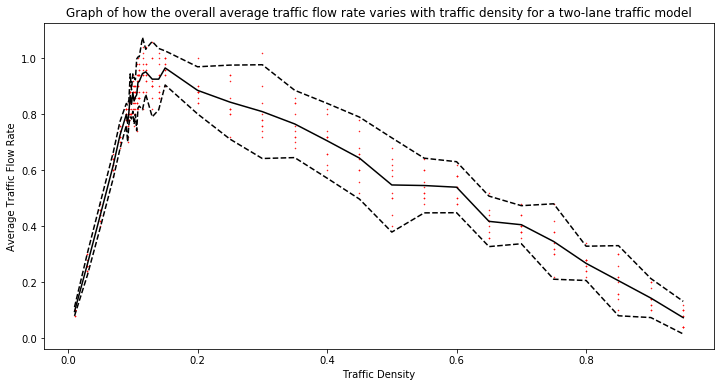

In [33]:
m = np.mean(np.array(data_flow2), axis=1)
s = np.std(np.array(data_flow2), axis=1)
plt.figure(figsize=(12, 6))
plt.plot(data_density2, data_flow2, 'r.', markersize=1)
plt.plot(data_density2, m, 'k-')
plt.plot(data_density2, m + 1.96*s, 'k--')
plt.plot(data_density2, m - 1.96*s, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Average Traffic Flow Rate')
plt.title('Graph of how the overall average traffic flow rate varies with traffic density for a two-lane traffic model')
plt.show()

Inferring from the graph above, we notice that as the traffic density increases, the traffic flow rate increases gradually until its optimum point at ``density ~ 0.25``, where the traffic flow rate is a little over 1. From that point on, the flow rate starts decreasing all the way down to zero, where ``density = 1`` and the cars can no longer move.

We also notice that the standard deviation (the dotted lines) is quite huge. This can be reduced greatly by increasing the number of ``run`` trials we perform above - but this also increases the time taken exponentially, even more than the one in the single-lane model since each trial for a two-lane model takes a little bit longer than its single-lane counterpart.

## Visualizing a 3-lane model

In [45]:
class ThreeLaneTrafficSimulation():
    def __init__(self, length = 100, density = 0.2, max_velocity = 5, slow_prob = 0.3, switch_prob = 0.5):
        '''Here, we define the model parameters (road length, traffic density, maximum velocity, 
        probability of slowing down)'''
        self.length = length # The length of the road (number of cells)
        self.density = density # The density of traffic
        self.max_velocity = max_velocity # The maximum speed of the cars
        self.slow_prob = slow_prob # The probability of slowing down for no apparent reason
        self.switch_prob = switch_prob # The probability of switching lanes
        
        '''Building the middle lane in a three-lane freeway model'''
        self.state = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.state[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
        
        '''Building the lower lane in a three-lane freeway model'''
        self.sister = -np.ones(self.length, dtype=int)
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.sister[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
        
        '''Building the upper lane in a two-lane freeway model'''
        self.brother = -np.ones(self.length, dtype=int)
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.brother[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
   
        '''Track the time steps and total number of cars that passed the simulation boundary 
        to estimate average traffic flow.'''
        self.time_step = 0
        self.cumulative_traffic_flow = 0
    
    def step(self, display = True):                
        
        self.state_orig = self.state.copy()
        self.sister_orig = self.sister.copy()
        self.brother_orig = self.brother.copy()

        for i in range(self.length):
            
            '''Coding the lane changing behavior for the cars in the middle lane'''
            if self.state[i] != -1: 
                
                dist_front = 0
                dist_sister_front = 0
                dist_sister_back = 0
                dist_brother_front = 0
                dist_brother_back = 0
                
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.sister[(i + (dist_sister_front + 1)) % self.length] == -1:
                    dist_sister_front += 1
                while self.sister[(i - (dist_sister_back + 1)) % self.length] == -1:
                    dist_sister_back +=1
                while self.brother[(i + (dist_brother_front + 1)) % self.length] == -1:
                    dist_brother_front += 1
                while self.brother[(i - (dist_brother_back + 1)) % self.length] == -1:
                    dist_brother_back +=1
                
                # For cars that are at the maximum velocity
                if self.state[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes
                    ## Looks at the sister lane ##
                    if dist_front < self.state[i] and self.sister[i] == -1 and dist_sister_front >= self.state[i] and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Looks at the brother lane ##
                    elif dist_front < self.state[i] and self.brother[i] == -1 and dist_brother_front >= self.state[i] and dist_brother_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
                
                # For cars that are not at the maximum velocity but is moving
                elif self.state[i] < self.max_velocity and self.state[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    ## Looks at the sister lane ##
                    if dist_front < self.state[i]+1 and self.sister[i] == -1 and dist_sister_front >= self.state[i]+1 and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Looks at the brother lane ##
                    elif dist_front < self.state[i]+1 and self.brother[i] == -1 and dist_brother_front >= self.state[i]+1 and dist_brother_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
        
                # For cars that are not moving
                elif self.state[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes
                    ## Looks at sister lane ##
                    if dist_front < self.state[i]+1 and self.sister[i] == -1 and dist_sister_front >= self.state[i]+1 and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob:
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Looks at brother lane ##
                    elif dist_front < self.state[i]+1 and self.brother[i] == -1 and dist_brother_front >= self.state[i]+1 and dist_brother_back >= self.max_velocity and np.random.random() < self.switch_prob:
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
            
                        
            '''Coding the lane changing behavior for the cars in the sister lane'''
            if self.sister_orig[i] != -1: 
                
                dist_sister_front = 0
                dist_front = 0
                dist_back = 0
               
                while self.sister_orig[(i + (dist_sister_front + 1)) % self.length] == -1:
                    dist_sister_front += 1
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.state[(i - (dist_back + 1)) % self.length] == -1:
                    dist_back += 1
                
                # For cars that are at the maximum velocity
                if self.sister_orig[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_sister_front < self.sister_orig[i] and self.state[i] == -1 and dist_front >= self.sister_orig[i] and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1
                
                # For cars that are NOT at the maximum velocity but are still moving
                elif self.sister_orig[i] < self.max_velocity and self.sister_orig[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_sister_front < self.sister_orig[i]+1 and self.state[i] == -1 and dist_front >= self.sister_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1

                # For cars that are not moving
                elif self.sister_orig[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes 
                    if dist_sister_front < self.sister_orig[i]+1 and self.state[i] == -1 and dist_front >= self.sister_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1

            '''Coding the lane changing behavior for the cars in the brother lane'''
            if self.brother_orig[i] != -1: 
                
                dist_brother_front = 0
                dist_front = 0
                dist_back = 0
               
                while self.brother_orig[(i + (dist_brother_front + 1)) % self.length] == -1:
                    dist_brother_front += 1
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.state[(i - (dist_back + 1)) % self.length] == -1:
                    dist_back += 1
                
                # For cars that are at the maximum velocity
                if self.brother_orig[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_brother_front < self.brother_orig[i] and self.state[i] == -1 and dist_front >= self.brother_orig[i] and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
                
                # For cars that are NOT at the maximum velocity but are still moving
                elif self.brother_orig[i] < self.max_velocity and self.brother_orig[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_brother_front < self.brother_orig[i]+1 and self.state[i] == -1 and dist_front >= self.brother_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1

                # For cars that are not moving
                elif self.brother_orig[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes 
                    if dist_brother_front < self.brother_orig[i]+1 and self.state[i] == -1 and dist_front >= self.brother_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
                        
            
            '''Coding the 3 rules for speed change in the original lane'''
            if self.state[i] != -1: 
                dist = 0 
                while self.state[(i + (dist + 1)) % self.length] == -1:
                    dist += 1
                if dist > self.state[i] and self.state[i] < self.max_velocity:
                    self.state[i] += 1
                if dist < self.state[i]:
                    self.state[i] = dist 
                if self.state[i] > 0 and np.random.random() < self.slow_prob:
                    self.state[i] -= 1    
            
            '''Coding the 3 rules for speed change in the sister lane'''
            if self.sister[i] != -1:
                dist_sister = 0
                while self.sister[(i + (dist_sister + 1)) % self.length] == -1:
                    dist_sister += 1
                if dist_sister > self.sister[i] and self.sister[i] < self.max_velocity:
                    self.sister[i] += 1
                if dist_sister < self.sister[i]:
                    self.sister[i] = dist_sister 
                if self.sister[i] > 0 and np.random.random() < self.slow_prob:
                    self.sister[i] -= 1 
                    
            '''Coding the 3 rules for speed change in the brother lane'''
            if self.brother[i] != -1:
                dist_brother = 0
                while self.brother[(i + (dist_brother + 1)) % self.length] == -1:
                    dist_brother += 1
                if dist_brother > self.brother[i] and self.brother[i] < self.max_velocity:
                    self.brother[i] += 1
                if dist_brother < self.brother[i]:
                    self.brother[i] = dist_brother
                if self.brother[i] > 0 and np.random.random() < self.slow_prob:
                    self.brother[i] -= 1 
        
        '''Coding the last rule in the Nagel-Schrekenberg model - the movement rule'''
        next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.state[i] != -1:
                next_state[(i + self.state[i]) % self.length] = self.state[i]
        self.state = next_state  
        
        next_sister = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.sister[i] != -1:
                next_sister[(i + self.sister[i]) % self.length] = self.sister[i]
        self.sister = next_sister
        
        next_brother = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.brother[i] != -1:
                next_brother[(i + self.brother[i]) % self.length] = self.brother[i]
        self.brother = next_brother

        
        '''Update time and traffic flow'''
        self.time_step += 1
        for i in range(self.max_velocity):
            if self.state[i] > i:
                self.cumulative_traffic_flow += 1
            if self.sister[i] > i:
                self.cumulative_traffic_flow += 1
        
        
        '''Display the function'''
        if display:
            self.display()
                    

    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.brother)) 
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        print(''.join('.' if x == -1 else str(x) for x in self.sister))      
        '''Here, I incorporated the following line to check if my cars were disappearing or not.'''
        # print(f"There are {sum([1 if x != -1 else 0 for x in self.state])+sum([1 if x != -1 else 0 for x in self.sister])+sum([1 if x != -1 else 0 for x in self.brother])} cars in total, with {sum([1 if x != -1 else 0 for x in self.brother])} cars in the top lane, {sum([1 if x != -1 else 0 for x in self.state])} cars in the middle lane and {sum([1 if x != -1 else 0 for x in self.sister])} cars in the bottom lane.")
        print('') #separate between two different time steps
  

sim = ThreeLaneTrafficSimulation()
sim.display()
for i in range(30):
    sim.step()  

...............2..51..5.1..1.....5........0..1....5..5.......5..4.50..3...0.....1......4......3.....
.......4.40........1.1...4.1........5.0.....3..1..1.5....0.......42.....5..0.2....................5.
..0.....1.45.......4....0........2........5....5..4.1..1..4.1..0..1.......1...2......2.0............

...........4.....20.1.0..1...2.......4....0....2....2....4.....20.0.1...2..1......2.........5.....4.
...5.....0.1.......0...2..1..2.......10.......2.1..1....40.......0...3....20....3...................
..0......10....4......3..1..........3.........4.1..1..2..2.1..2.1...2......1.....3....1.1...........

...5............50.10..1...2....3........40.......3...2.......500.0...2...2..2.......3..........4...
........5.1..2......1....2..2...3....0.1......0..1...2..0.1.......1.....3.0.1.......4...............
...1.....00.........5...2.1.............4.....0...2..2..2.1..2.1..2....3.....2.......4.1.1..........

4......4........0.10.1...2....3.....4....0.1.........3..2.....000..1.....3.1...2........

## Calculating Traffic Flow For Three-Lane Traffic Model

Since we have already modified the code above to include a flow counter in the initialization method, as well as at the end of the step method, we can start running the simulation a bunch of times to get the average traffic flow for each.

In [41]:
data_flow3 = []
data_density3 = []
for density in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    #print('Density:', density)
    data_density3.append(density)
    data_flow3.append([])
    for run in range(10):
        sim = ThreeLaneTrafficSimulation(density=density)
        for i in range(50):
            sim.step(display=False)
        data_flow3[-1].append(sim.cumulative_traffic_flow / sim.time_step)

Finally, we will plot the results into a graph and to visualize the flow of traffic over various densities of traffic for a three-lane traffic model.

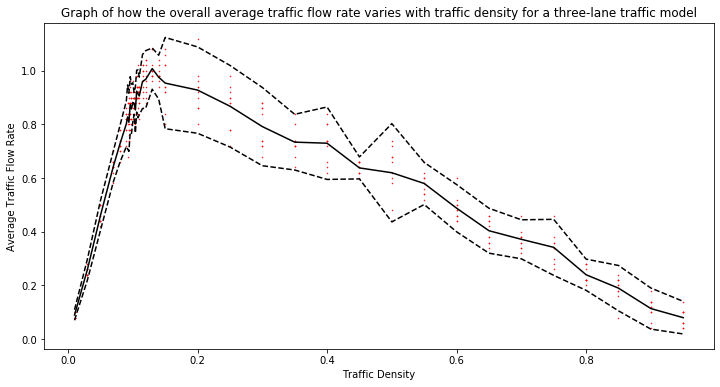

In [42]:
m = np.mean(np.array(data_flow3), axis=1)
s = np.std(np.array(data_flow3), axis=1)
plt.figure(figsize=(12, 6))
plt.plot(data_density3, data_flow3, 'r.', markersize=1)
plt.plot(data_density3, m, 'k-')
plt.plot(data_density3, m + 1.96*s, 'k--')
plt.plot(data_density3, m - 1.96*s, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Average Traffic Flow Rate')
plt.title('Graph of how the overall average traffic flow rate varies with traffic density for a three-lane traffic model')
plt.show()

Inferring from the graph above, we notice that as the traffic density increases, the traffic flow rate increases gradually until its optimum point at ``density ~ 0.25``, where the traffic flow rate is a little over 1. From that point on, the flow rate starts decreasing all the way down to zero, where ``density = 1`` and the cars can no longer move.

We also notice that the standard deviation (the dotted lines) is quite huge. This can be reduced greatly by increasing the number of ``run`` trials we perform above - but this also increases the time taken exponentially, even more than the one in the two-lane model since each trial for a three-lane model takes much longer than its two-lane counterpart.

## Composite graph showing the scalability of one-lane, two-lane, and three-lane models as the traffic density increases.

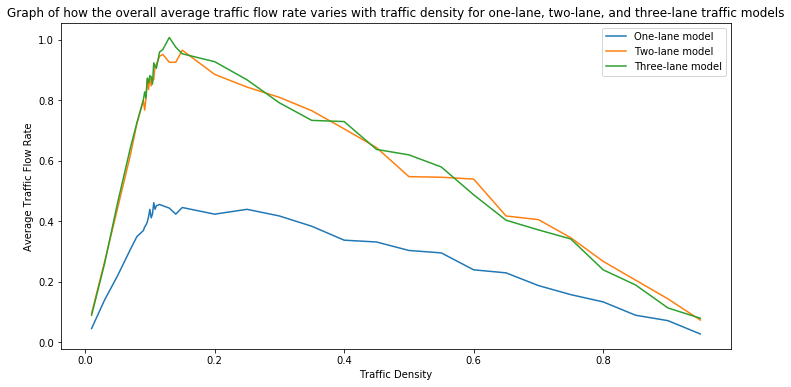

In [43]:
m = np.mean(np.array(data_flow), axis=1)
m2 = np.mean(np.array(data_flow2), axis=1)
m3 = np.mean(np.array(data_flow3), axis=1)
plt.figure(figsize=(12, 6))
plt.plot(data_density, m, label = "One-lane model")
plt.plot(data_density2, m2, label = "Two-lane model")
plt.plot(data_density3, m3, label = "Three-lane model")
plt.xlabel('Traffic Density')
plt.ylabel('Average Traffic Flow Rate')
plt.legend()
plt.title('Graph of how the overall average traffic flow rate varies with traffic density for one-lane, two-lane, and three-lane traffic models')
plt.show()

# Report

As seen from the results above, both the two-lane and the three-lane model have significantly higher capacity compared to the single-lane model as they both have almost double the average traffic flow rate of the single-lane model as the traffic density increases. They both have peaks at around 1, as opposed to the single-model's measly 0.5.

This is understandable, since both the two-lane and three-lane models allow the cars to switch lanes whenever a jam starts to build up. This diffuses the traffic jams and allows for the traffic flow to stay constant. 

## About the Model

All three of the models that I created above consists of a single ``TrafficSimulation()`` class and three different methods:
- The ``__init__()`` method, which intializes the object (both the road the the cars in it), sets the initial parameters, and also sets the timestep and flow counter.
- The ``step()`` method, which denotes the following behaviors of the model:
    - The lane changing behavior for the cars in all of the lanes (only applicable for two-lane and three-lane models). This has to go first because it technically is a half-time-step, where there is no movement involved except for the switching of lanes of some of the cars.
    - The speed changing behavior for the cars in all of the lanes. This can involve acceleration, deceleration, and a random slowdown determined by the ``slow_prob()``.
    - The traffic flow counter.
    - It also calls on the ``display()`` method to print out the state of the road at the end of every time step.
- The ``display()`` method, which prints out the state of the road. For two and three-lane models, it includes a "divider", which is basically a space to distinguish between the output for different timesteps.


Here are a few assumptions that were made in the simulations above: 
- The density of the number of cars distributed over the roads was kept constant at 0.2 for all three models to ensure that a fair comparison can be made.
- The probability that the drivers would slow down randomly was fixed at 0.3 for all three types of traffic models above. This means each car has a 30% chance of slowing down randomly.
- The probability that the drivers would switch lanes was fixed at 0.5 for the two-lane and three-lane traffic models above. This means each car has a 50% chance of changing lanes when it has the chance to do so.


## Location-Based Assessment
I believe that the models above are very applicable to the Autobahn in Berlin/Germany. Having driven on the Autobahn myself, I can see how traffic jams are more prone to happen at sections of the Autobahn where there are only one or two lanes (due to road-work/construction), while for the rest of the Autobahn where there are three lanes, jams are less likely to happen.

# Stretch Goal
Describe and analyze how good and bad driver behaviors affect traffic flow and traffic jams on multi-lane highways. In order to analyze behavior, you will need to encode bad driver behavior in your cellular automaton update rule, run the simulation and report on how particular behaviors affect traffic flow and traffic jams. Key question: What do your results imply about how self-driving cars should be programmed?

## Example 1: Distracted Drivers

The most common example of bad driver behavior would be drivers who slow down randomly _very_ often, perhaps because they are distracted by their phones or by an attractive person walking along the sidewalk. This can be modeled by simply increasing the ``slow_prob`` attribute in the initialization method - in this case, I'm increasing it to ``slow_prob = 0.9``, let's see how things go...

In [49]:
sim = ThreeLaneTrafficSimulation(slow_prob=0.9)
sim.display()
for i in range(30):
    sim.step()  

..0....3......3...4.....2.1..........2......2...30.4......0......33....0..1...5...3....0.........4..
..........3...............5...043......33.....2.13.....4.01.....23...........5...........15..3.....4
5.0...1.........1.....3..5.....2............5................5.....23.....3......53..5.1...5222.....

3.0.......3.....2.....4.0..1............3.....2.00.....4..0......0...3.0...1....2....3.0............
...4.........3..............2.00...3.......3..0.0...3....0.1....0...3.............5......0.1....3...
0.0....1..........2....1.....4...2........3.....4..........4.....4.0...3.....3...0.1.0..1..000..2...

0.0..........3....2....10...1..............3...100......1.0......0...0.0....1.....2..0.0............
.......4........3...........0.00......3.....1.0.0......3.0..1...0......3........3......5.0..1......3
0.0......2..........2...1......2...2.........3......4..........4.0..1.....3......0.0..1...2000....2.

0.0.............3...2..00....1...............2.000......0.0......0....10.....1.....1.0.0

As you can see, there are traffic jams _everywhere_ along the road, which greatly reduces the traffic flow rate. Let's model the graph of how the flow of traffic varies over different densities of traffic for this dysfunctional three-lane traffic model.

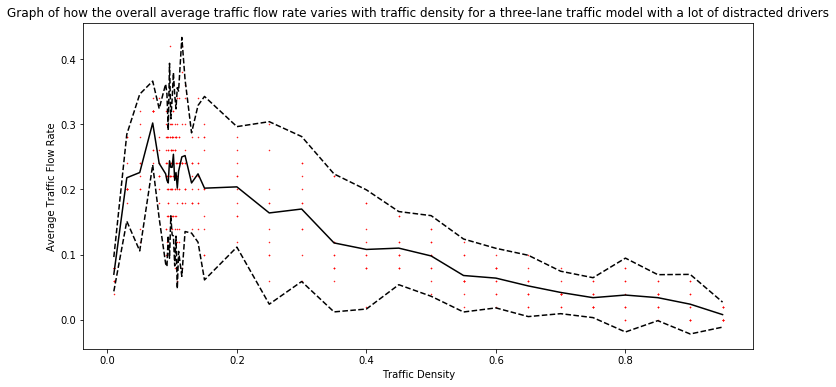

In [50]:
data_flow4 = []
data_density4 = []
for density in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    #print('Density:', density)
    data_density4.append(density)
    data_flow4.append([])
    for run in range(10):
        sim = ThreeLaneTrafficSimulation(density=density, slow_prob=0.9)
        for i in range(50):
            sim.step(display=False)
        data_flow4[-1].append(sim.cumulative_traffic_flow / sim.time_step)
        
m = np.mean(np.array(data_flow4), axis=1)
s = np.std(np.array(data_flow4), axis=1)
plt.figure(figsize=(12, 6))
plt.plot(data_density4, data_flow4, 'r.', markersize=1)
plt.plot(data_density4, m, 'k-')
plt.plot(data_density4, m + 1.96*s, 'k--')
plt.plot(data_density4, m - 1.96*s, 'k--')
plt.xlabel('Traffic Density')
plt.ylabel('Average Traffic Flow Rate')
plt.title('Graph of how the overall average traffic flow rate varies with traffic density for a three-lane traffic model with a lot of distracted drivers')
plt.show()

As you can see from the graph above, the capacity of the three-lane model decreased _significantly_. The peak of the graph is now at 0.4 - barely reaching half of the original peak. This makes sense, since the more traffic jams, the slower the traffic flow rate of the model.

Moral of the story? Don't text and drive, and don't get distracted by attractive people along the sidewalk.

## Example 2: Reckless Drivers

In this next example, we want to model a scenario where there are reckless drivers - drivers who switch lanes anyways despite there being a car coming from behind in the other lane.

However, this is a little more complicated to model - we will have to add a new attribute/parameter within the ``__init__()`` method and change the code body of the ``step()`` method.

In [64]:
class RecklessThreeLaneTrafficSimulation():
    def __init__(self, length = 100, density = 0.2, max_velocity = 5, slow_prob = 0.3, switch_prob = 0.5, rebel_prob = 0.3):
        '''Here, we define the model parameters (road length, traffic density, maximum velocity, 
        probability of slowing down)'''
        self.length = length # The length of the road (number of cells)
        self.density = density # The density of traffic
        self.max_velocity = max_velocity # The maximum speed of the cars
        self.slow_prob = slow_prob # The probability of slowing down for no apparent reason
        self.switch_prob = switch_prob # The probability of switching lanes
        self.rebel_prob = rebel_prob # The probability of switching lanes despite there being a car 
                                     # coming from behind in the other lane.
        
        '''Building the middle lane in a three-lane freeway model'''
        self.state = -np.ones(self.length, dtype=int) # "-1" represents an empty cell
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.state[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
        
        '''Building the lower lane in a three-lane freeway model'''
        self.sister = -np.ones(self.length, dtype=int)
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.sister[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
        
        '''Building the upper lane in a two-lane freeway model'''
        self.brother = -np.ones(self.length, dtype=int)
        filled_cells = np.random.choice(range(self.length), size=int(round((density * self.length))), replace=False)
        self.brother[filled_cells] = np.random.randint(0, self.max_velocity + 1, size=len(filled_cells))
   
        '''Track the time steps and total number of cars that passed the simulation boundary 
        to estimate average traffic flow.'''
        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        '''Track the number of cars left - there will be a lot of accidents happening, so we want to 
        track how many cars survive this carnage'''
        self.cars_left = density*self.length
    
    def step(self, display = True):                
        
        self.state_orig = self.state.copy()
        self.sister_orig = self.sister.copy()
        self.brother_orig = self.brother.copy()

        for i in range(self.length):
            
            '''Coding the lane changing behavior for the cars in the middle lane'''
            if self.state[i] != -1: 
                
                dist_front = 0
                dist_sister_front = 0
                dist_sister_back = 0
                dist_brother_front = 0
                dist_brother_back = 0
                
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.sister[(i + (dist_sister_front + 1)) % self.length] == -1:
                    dist_sister_front += 1
                while self.sister[(i - (dist_sister_back + 1)) % self.length] == -1:
                    dist_sister_back +=1
                while self.brother[(i + (dist_brother_front + 1)) % self.length] == -1:
                    dist_brother_front += 1
                while self.brother[(i - (dist_brother_back + 1)) % self.length] == -1:
                    dist_brother_back +=1
                
                # For cars that are at the maximum velocity
                if self.state[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes
                    ## Looks at the sister lane ##
                    if dist_front < self.state[i] and self.sister[i] == -1 and dist_sister_front >= self.state[i] and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Looks at the brother lane ##
                    elif dist_front < self.state[i] and self.brother[i] == -1 and dist_brother_front >= self.state[i] and dist_brother_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the sister lane##
                    elif self.sister[i] == -1 and np.random.random() < self.rebel_prob:
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the brother lane##
                    elif self.brother[i] == -1 and np.random.random() < self.rebel_prob:
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
                        
                
                # For cars that are not at the maximum velocity but is moving
                elif self.state[i] < self.max_velocity and self.state[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    ## Looks at the sister lane ##
                    if dist_front < self.state[i]+1 and self.sister[i] == -1 and dist_sister_front >= self.state[i]+1 and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Looks at the brother lane ##
                    elif dist_front < self.state[i]+1 and self.brother[i] == -1 and dist_brother_front >= self.state[i]+1 and dist_brother_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the sister lane##
                    elif self.sister[i] == -1 and np.random.random() < self.rebel_prob:
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the brother lane##
                    elif self.brother[i] == -1 and np.random.random() < self.rebel_prob:
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
        
                # For cars that are not moving
                elif self.state[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes
                    ## Looks at sister lane ##
                    if dist_front < self.state[i]+1 and self.sister[i] == -1 and dist_sister_front >= self.state[i]+1 and dist_sister_back >= self.max_velocity and np.random.random() < self.switch_prob:
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Looks at brother lane ##
                    elif dist_front < self.state[i]+1 and self.brother[i] == -1 and dist_brother_front >= self.state[i]+1 and dist_brother_back >= self.max_velocity and np.random.random() < self.switch_prob:
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the sister lane##
                    elif self.sister[i] == -1 and np.random.random() < self.rebel_prob:
                        self.sister[i] = self.state[i]
                        self.state[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the brother lane##
                    elif self.brother[i] == -1 and np.random.random() < self.rebel_prob:
                        self.brother[i] = self.state[i]
                        self.state[i] = -1
            
                        
            '''Coding the lane changing behavior for the cars in the sister lane'''
            if self.sister_orig[i] != -1: 
                
                dist_sister_front = 0
                dist_front = 0
                dist_back = 0
               
                while self.sister_orig[(i + (dist_sister_front + 1)) % self.length] == -1:
                    dist_sister_front += 1
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.state[(i - (dist_back + 1)) % self.length] == -1:
                    dist_back += 1
                
                # For cars that are at the maximum velocity
                if self.sister_orig[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_sister_front < self.sister_orig[i] and self.state[i] == -1 and dist_front >= self.sister_orig[i] and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the middle lane##
                    elif self.state[i] == -1 and np.random.random() < self.rebel_prob:
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1
                
                # For cars that are NOT at the maximum velocity but are still moving
                elif self.sister_orig[i] < self.max_velocity and self.sister_orig[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_sister_front < self.sister_orig[i]+1 and self.state[i] == -1 and dist_front >= self.sister_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the middle lane##
                    elif self.state[i] == -1 and np.random.random() < self.rebel_prob:
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1

                # For cars that are not moving
                elif self.sister_orig[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes 
                    if dist_sister_front < self.sister_orig[i]+1 and self.state[i] == -1 and dist_front >= self.sister_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the middle lane##
                    elif self.state[i] == -1 and np.random.random() < self.rebel_prob:
                        self.state[i] = self.sister_orig[i]
                        self.sister[i] = -1

            '''Coding the lane changing behavior for the cars in the brother lane'''
            if self.brother_orig[i] != -1: 
                
                dist_brother_front = 0
                dist_front = 0
                dist_back = 0
               
                while self.brother_orig[(i + (dist_brother_front + 1)) % self.length] == -1:
                    dist_brother_front += 1
                while self.state[(i + (dist_front + 1)) % self.length] == -1:
                    dist_front += 1
                while self.state[(i - (dist_back + 1)) % self.length] == -1:
                    dist_back += 1
                
                # For cars that are at the maximum velocity
                if self.brother_orig[i] == self.max_velocity:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_brother_front < self.brother_orig[i] and self.state[i] == -1 and dist_front >= self.brother_orig[i] and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the middle lane##
                    elif self.state[i] == -1 and np.random.random() < self.rebel_prob:
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
                
                # For cars that are NOT at the maximum velocity but are still moving
                elif self.brother_orig[i] < self.max_velocity and self.brother_orig[i] > 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver actually wants to switch lanes and won't slow down randomly
                    if dist_brother_front < self.brother_orig[i]+1 and self.state[i] == -1 and dist_front >= self.brother_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the middle lane##
                    elif self.state[i] == -1 and np.random.random() < self.rebel_prob:
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1

                # For cars that are not moving
                elif self.brother_orig[i] == 0:
                    # For the situation where there's not enough space in front and there's space for it to go to the other lane and the driver decides to switch lanes 
                    if dist_brother_front < self.brother_orig[i]+1 and self.state[i] == -1 and dist_front >= self.brother_orig[i]+1 and dist_back >= self.max_velocity and np.random.random() < self.switch_prob: 
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
                    ## Reckless behavior of switching lanes despite there being a car coming from behind in the middle lane##
                    elif self.state[i] == -1 and np.random.random() < self.rebel_prob:
                        self.state[i] = self.brother_orig[i]
                        self.brother[i] = -1
            
            '''Coding the 3 rules for speed change in the original lane'''
            if self.state[i] != -1: 
                dist = 0 
                while self.state[(i + (dist + 1)) % self.length] == -1:
                    dist += 1
                if dist > self.state[i] and self.state[i] < self.max_velocity:
                    self.state[i] += 1
                if dist < self.state[i]:
                    self.state[i] = dist 
                if self.state[i] > 0 and np.random.random() < self.slow_prob:
                    self.state[i] -= 1    
            
            '''Coding the 3 rules for speed change in the sister lane'''
            if self.sister[i] != -1:
                dist_sister = 0
                while self.sister[(i + (dist_sister + 1)) % self.length] == -1:
                    dist_sister += 1
                if dist_sister > self.sister[i] and self.sister[i] < self.max_velocity:
                    self.sister[i] += 1
                if dist_sister < self.sister[i]:
                    self.sister[i] = dist_sister 
                if self.sister[i] > 0 and np.random.random() < self.slow_prob:
                    self.sister[i] -= 1 
                    
            '''Coding the 3 rules for speed change in the brother lane'''
            if self.brother[i] != -1:
                dist_brother = 0
                while self.brother[(i + (dist_brother + 1)) % self.length] == -1:
                    dist_brother += 1
                if dist_brother > self.brother[i] and self.brother[i] < self.max_velocity:
                    self.brother[i] += 1
                if dist_brother < self.brother[i]:
                    self.brother[i] = dist_brother
                if self.brother[i] > 0 and np.random.random() < self.slow_prob:
                    self.brother[i] -= 1 
        
        '''Coding the last rule in the Nagel-Schrekenberg model - the movement rule'''
        next_state = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.state[i] != -1:
                next_state[(i + self.state[i]) % self.length] = self.state[i]
        self.state = next_state  
        
        next_sister = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.sister[i] != -1:
                next_sister[(i + self.sister[i]) % self.length] = self.sister[i]
        self.sister = next_sister
        
        next_brother = -np.ones(self.length, dtype=int) 
        for i in range(self.length):
            if self.brother[i] != -1:
                next_brother[(i + self.brother[i]) % self.length] = self.brother[i]
        self.brother = next_brother

        
        '''Update time and traffic flow'''
        self.time_step += 1
        for i in range(self.max_velocity):
            if self.state[i] > i:
                self.cumulative_traffic_flow += 1
            if self.sister[i] > i:
                self.cumulative_traffic_flow += 1
        
        
        '''Display the function'''
        if display:
            self.display()
                    

    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.brother)) 
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        print(''.join('.' if x == -1 else str(x) for x in self.sister))      
        '''Here, I incorporated the following line to check if the cars are getting into accidents - if they are, they will disappear from the road.'''
        print(f"There are {sum([1 if x != -1 else 0 for x in self.state])+sum([1 if x != -1 else 0 for x in self.sister])+sum([1 if x != -1 else 0 for x in self.brother])} cars in total, with {sum([1 if x != -1 else 0 for x in self.brother])} cars in the top lane, {sum([1 if x != -1 else 0 for x in self.state])} cars in the middle lane and {sum([1 if x != -1 else 0 for x in self.sister])} cars in the bottom lane.")
        print('') #separate between two different time steps
        
        '''Update the number of cars left'''
        self.cars_left = sum([1 if x != -1 else 0 for x in self.state])+sum([1 if x != -1 else 0 for x in self.sister])+sum([1 if x != -1 else 0 for x in self.brother])
  

sim = ThreeLaneTrafficSimulation()
sim.display()
for i in range(30):
    sim.step()

........5.2.....2..........................4....4.0....2...21.5..51.5.....5..1..3...0.1.....4......1
0.5..........2.1...3.3..4........................2.3.....4...1.....1....5....03..3.0..5...........41
..55.1..4......5..5..........5...5...21...........1.5......2.4.....4.......2.2..........1.....0....1
There are 60 cars in total, with 20 cars in the top lane, 20 cars in the middle lane and 20 cars in the bottom lane.

.2.......1..2......3........4.................3...0......2.0.1..2........1.1..0....00...2.........0.
.1....425...4.1..2....1................1........0.0.....4...1..2..0..2.......0..0..........5.....5.0
.20.............1.....35........3...3..............0..............5.....5...1...3...3.....2...0.....
There are 54 cars in total, with 18 cars in the top lane, 21 cars in the middle lane and 15 cars in the bottom lane.

...2....2..2.....................................3.1........1..0..........1.1.0..1.........3........
1..1...0.....1..0...1...2...5....5....2..2.......1.1.....

As you can see from the results above, even at ``rebel_prob = 0.3``, there is already a lot of cars getting into accidents and disappearing from the road. We can expect this number to increase as the value of `rebel_prob`` increases, so let's visualize this with a Monte Carlo simulation.

In [ ]:
data_cars_left = []
data_rebel_prob = []
for rebel in np.concatenate((
    np.arange(0.01, 0.079, 0.02), [0.08],
    np.arange(0.09, 0.109, 0.002),
    [0.11, 0.115, 0.12, 0.13, 0.14],
    np.arange(0.15, 1, 0.05)
)):
    #print('Density:', density)
    data_rebel_prob.append(rebel)
    data_cars_left.append([])
    for run in range(10):
        sim = RecklessThreeLaneTrafficSimulation(rebel_prob=rebel)
        for i in range(50):
            sim.step(display=False)
        data_cars_left[-1].append(sim.cars_left)
        
m = np.mean(np.array(data_cars_left), axis=1)
s = np.std(np.array(data_cars_left), axis=1)
plt.figure(figsize=(12, 6))
plt.plot(data_rebel_prob, data_cars_left, 'r.', markersize=1)
plt.plot(data_rebel_prob, m, 'k-')
plt.plot(data_rebel_prob, m + 1.96*s, 'k--')
plt.plot(data_rebel_prob, m - 1.96*s, 'k--')
plt.xlabel('Probability of Drivers Switching Lanes Recklessly')
plt.ylabel('Average Number of Cars Left After 50 Generations')
plt.title('Graph of how the overall average number of cars left varies with the probability of drivers switching lanes recklessly for a three-lane traffic model')
plt.show()

Unfortunately, my code didn't manage to run in time - there must be a bug somewhere in the syntax above/in the code body itself that I wasn't able to identify in time. :( 

But it is safe to say that reckless driving is the number one leading cause of road accidents in the world, so moral of the story? Drive safe - you can't get home, unless you're safe.